In [57]:
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import pandas_ta as pta
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
import ta
import pandas as pd

In [58]:
class AdxSmaCciStrategy(Strategy):
    def __init__(self, params: dict):
        super().__init__()
        self.cci_length = params.get('cci_length', 72)
        self.cci_threshold = params.get('cci_threshold', 120)
        self.sma_length_short = params.get('sma_length_short', 6)
        self.sma_length_long = params.get('sma_length_long', 72)
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 40)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate CCI
        data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=self.cci_length)

        # Calculate SMA
        data['sma_short'] = pta.sma(data['close'], length=self.sma_length_short)
        data['sma_long'] = pta.sma(data['close'], length=self.sma_length_long)

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Define signals
        data['cci_bullish'] = data['cci'] < self.cci_threshold
        data['sma_buy'] = (data['sma_short'] > data['sma_long']) & (data['close'] > data['sma_short'])
        data['strong_trend'] = data['adx'] > self.adx_threshold

        # Combine signals
        data['long_entry'] = (
            data['sma_buy']
            & data['cci_bullish']
            & data['strong_trend']
        )

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [59]:
class AdxEmaRsiStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.sma_length_short = params.get('sma_length_short', 6)
        self.sma_length_long = params.get('sma_length_long', 72)
        self.rsi_length = params.get('rsi_length', 48)
        self.rsi_not_overbought = params.get('rsi_not_overbought', 70)
        self.v_width = params.get('v_width', 12)
        self.trail_percentage = params.get('trail_percentage', 0.02)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.05)

    def is_local_minima(self, series, lookback=3):
        # Ensure the lookback value is appropriate for the calculation
        if lookback < 2:
            raise ValueError("Lookback must be at least 2.")
    
        # Calculate the midpoint for splitting the lookback period
        midpoint = lookback // 2  # Integer division to ensure midpoint is an integer
    
        # Conditions for detecting a local minima
        # The first half should be decreasing (negative difference)
        conditions = [(series.shift(i) < 0) for i in range(lookback-1, midpoint-1, -1)]
    
        # The second half should be increasing (positive difference)
        conditions.extend([(series.shift(i) > 0) for i in range(midpoint-1, 0, -1)])
    
        # Check if all conditions are met
        return pd.concat(conditions, axis=1).all(axis=1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        data['adx'] = adx['ADX_' + str(self.adx_length)]

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=self.rsi_length)

        # Calculate SMA
        data['sma_short'] = pta.sma(data['close'], length=self.sma_length_short)
        data['sma_long'] = pta.sma(data['close'], length=self.sma_length_long)        

        # diff
        data['sma_long_diff'] = data['sma_long'].diff()

        # Apply the function to detect local minima
        data['sma_long_minima'] = self.is_local_minima(data['sma_long_diff'], self.v_width)

        # Define signals
        data['strong_trend'] = (data['adx'] > self.adx_threshold)
        data['rsi_not_overbought'] = data['rsi'] < self.rsi_not_overbought
        data['sma_buy'] = (data['sma_short'] > data['sma_long'])

        # Combine all conditions for long entry
        data['long_entry'] = (
            data['strong_trend'] &
            data['rsi_not_overbought'] &
            data['sma_buy'] &
            data['sma_long_minima'] 
        )

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


In [60]:
class AdxEmaStrategy(Strategy):
    def __init__(self, params=None):
        super().__init__()
        self.adx_length = params.get('adx_length', 24)
        self.adx_threshold = params.get('adx_threshold', 30)
        self.ema_length_short = params.get('ema_length_short', 24)
        self.ema_length_long = params.get('ema_length_long', 168)
        self.trail_percentage = params.get('trail_percentage', 0.05)
        self.take_profit_percentage = params.get('take_profit_percentage', 0.1)

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()

        # Calculate ADX
        adx = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length)
        adx_short = pta.adx(data['high'], data['low'], data['close'], length=self.adx_length / 2)
        data['adx_long'] = adx['ADX_' + str(self.adx_length)]
        data['adx_short'] = adx_short['ADX_' + str(self.adx_length / 2)]

        # Calculate EMA
        data['ema_short'] = pta.ema(data['close'], length=self.ema_length_short)
        data['ema_long'] = pta.ema(data['close'], length=self.ema_length_long)

        # Define signals
        data['strong_trend'] = (data['adx_short'] > self.adx_threshold * 2) & (data['adx_long'] > self.adx_threshold)
        data['ema_buy'] = (data['ema_short'] > data['ema_long']) & (data['close'] > data['ema_short'])

        # Combine all conditions for long entry
        data['long_entry'] = (data['strong_trend'] & data['ema_buy'])

        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=self.trail_percentage, take_profit_percentage=self.take_profit_percentage)


Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 7.222735987909817e-05 with quantity 13789788.26953125, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 7.222735987909817e-05 with quantity 13789788.26953125, total cost £999.984 and transaction cost £3.984
        Bought 13789788.26953125 BTC-GBP at 7.222735987909817e-05 on 03/12/2022 05:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 7.222735987909817e-05 with quantity 13789788.26953125, trail 0.05, limit None, stop None, take_profit None
    Updated trailing stop to 6.879616479361136e-05
    Updated trailing stop to 6.882822488421444e-05
    Updated trailing stop to 6.889496639732892e-05
    Updated trailing stop to 6.896418677316048e-05
    Creating TRAILING_STOP SELL order for BTC-GBP at 7.257555476711539e-05 with quantity 13789788.26953125, trail 0.04919846621770951, l

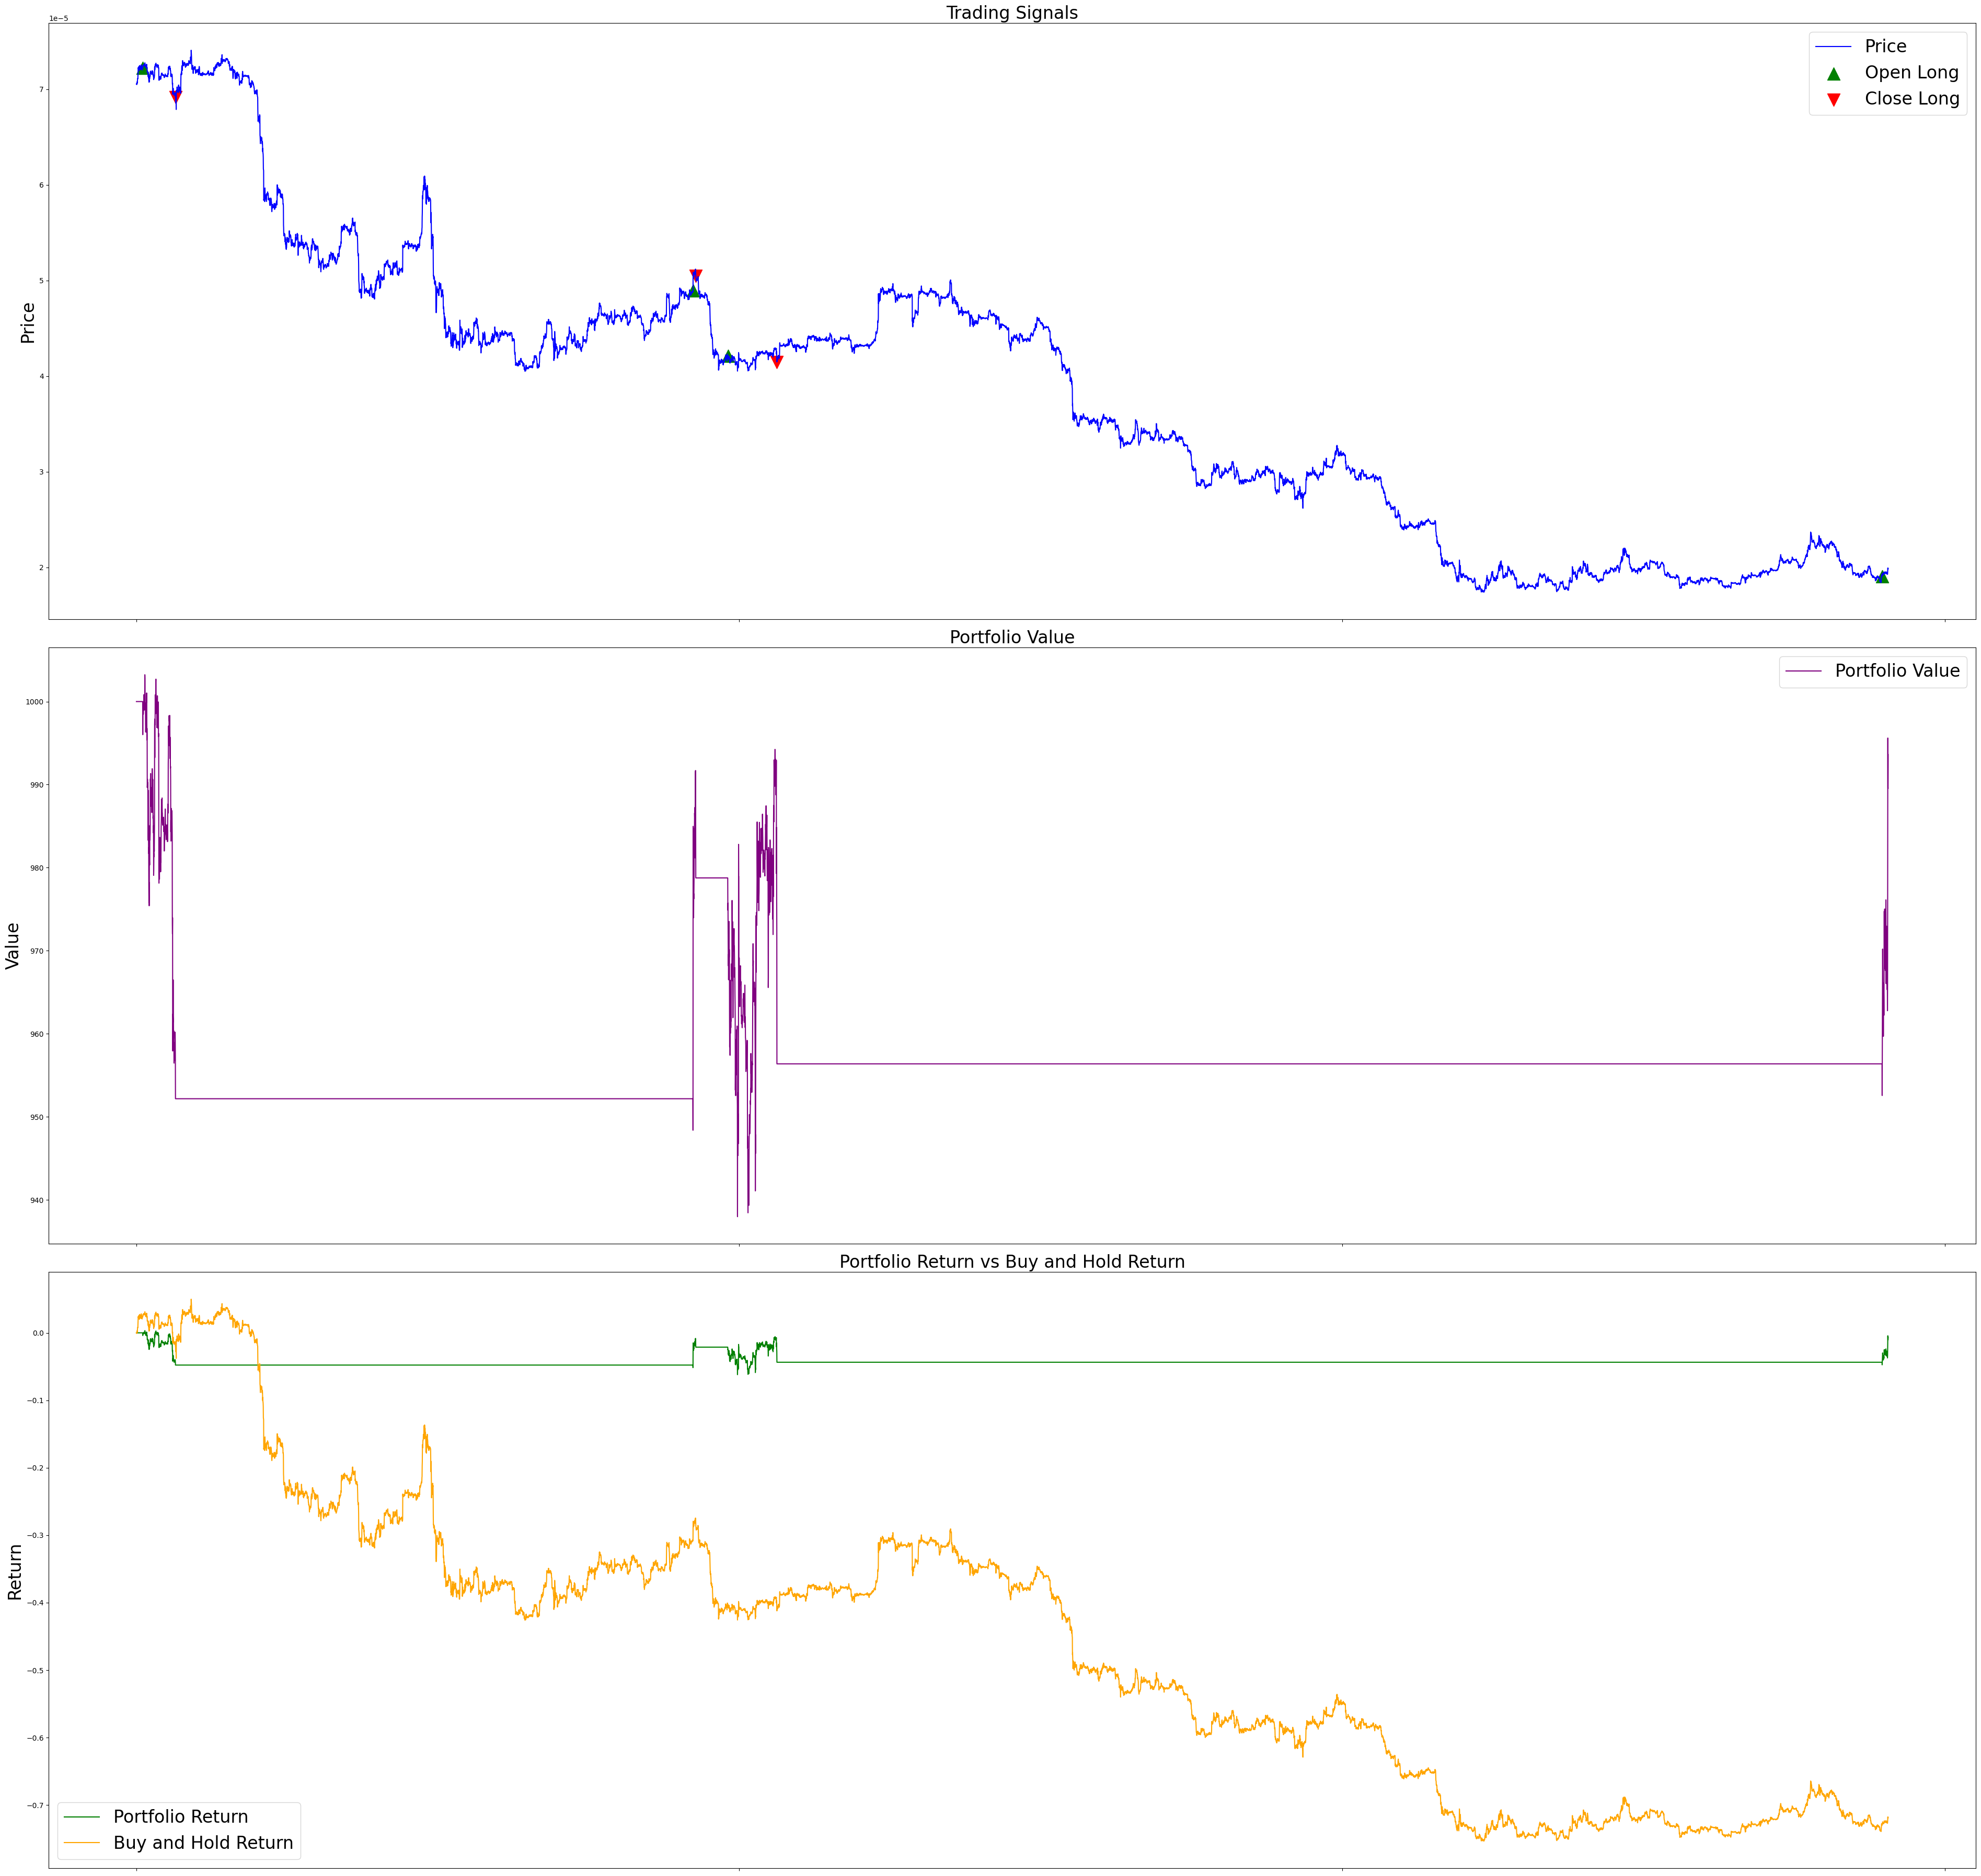

In [73]:
import csv
from datetime import datetime

# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

#SYMBOL = "ETH-BTC"
#SYMBOL = "SOL-BTC"
SYMBOL = "BTC-GBP"
#SYMBOL = "USD-BTC"
train_since = pd.to_datetime('2022-09-01').tz_localize('UTC')
start_date = pd.to_datetime('2022-12-01').tz_localize('UTC')
end_date = pd.to_datetime('2024-08-01').tz_localize('UTC')
period = 168
frequency = '1h'

strategy_params = {
    'invert_pair': True,

    'trail_percentage': 0.05,
    'take_profit_percentage': 0.05,
    
    #'cci_length': 48,
    #'cci_threshold': 0,
    #'adx_length': 24,
    #'adx_threshold': 20,
    #'sma_length_short': 12,
    #'sma_length_long': 72,

    'rsi_length': 24,
    'rsi_not_overbought': 60,
    'sma_length_short': 6,
    'sma_length_long': 72,
    'adx_length': 12,
    'adx_threshold': 30,
    'v_width': 12,

    #'adx_length': 12,
    #'adx_threshold': 40,
    #'ema_length_short': 6,
    #'ema_length_long': 48,
}

feed = YFinanceFeed(interval = frequency, invert_pair = strategy_params['invert_pair'])

#strategy = AdxSmaCciStrategy(strategy_params)
strategy = AdxEmaRsiStrategy(strategy_params)
#strategy = AdxEmaStrategy(strategy_params)

trader = Trader(SYMBOL, 1000, feed, strategy)

portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

perf = portfolio.plot_performance()


In [74]:
import os

# CSV file path
csv_file = f'performance_tests.csv'

# Define the header
header = [
    'strategy', 'symbol', 'invert_pair', 'start_date', 'end_date', 'frequency', 'cci_length', 'cci_threshold',
    'adx_length', 'adx_threshold', 'rsi_length', 'rsi_oversold', 'rsi_not_overbought', 'ema_length', 'ema_length_short',
    'ema_length_long', 'sma_length_short', 'sma_length_long', 'v_width', 'supertrend_length', 'supertrend_multiplier', 
    'trail_percentage', 'take_profit_percentage', 'win_rate', 'portfolio_return', 'asset_return', 'portfolio_max_drawdown',
    'asset_max_drawdown', 'portfolio_id'
]

# Check if the file exists and is empty
file_exists = os.path.isfile(csv_file)
file_empty = file_exists and os.path.getsize(csv_file) == 0

# Open the file in append mode
with open(csv_file, 'a', newline='') as f:
    writer = csv.writer(f)
    
    # Write header if file is empty or doesn't exist
    if not file_exists or file_empty:
        writer.writerow(header)
    
    # Write the data
    writer.writerow([
        strategy.__class__.__name__,
        SYMBOL,
        strategy_params['invert_pair'],
        start_date.strftime('%Y-%m-%d'),
        end_date.strftime('%Y-%m-%d'),
        frequency,
        strategy_params.get('cci_length', ''),
        strategy_params.get('cci_threshold', ''),
        strategy_params.get('adx_length', ''),
        strategy_params.get('adx_threshold', ''),
        strategy_params.get('rsi_length', ''),
        strategy_params.get('rsi_oversold', ''),
        strategy_params.get('rsi_not_overbought', ''),
        strategy_params.get('ema_length', ''),
        strategy_params.get('ema_length_short', ''),
        strategy_params.get('ema_length_long', ''),
        strategy_params.get('sma_length_short', ''),
        strategy_params.get('sma_length_long', ''),
        strategy_params.get('v_width', ''),
        strategy_params.get('supertrend_length', ''),
        strategy_params.get('supertrend_multiplier', ''),
        strategy_params['trail_percentage'],
        strategy_params['take_profit_percentage'],
        perf['win_rate'],
        perf['portfolio_return'],
        perf['asset_return'],
        perf['portfolio_max_drawdown'],
        perf['asset_max_drawdown'],
        portfolio.uuid
    ])